# `StableSpectralElements.jl` - 2D isentropic vortex example

First, let's load the packages used in this example.

In [17]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs

We will be solving the two-dimensional compressible Euler equations, which are a hyperbolic system of conservation laws given by
\begin{align}
\partial_t \rho(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot \big( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \big) &= 0,\\
\partial_t \big( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \big) + \nabla_{\boldsymbol{x}} \cdot \big( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \otimes \boldsymbol{V}(\boldsymbol{x},t) + p (\boldsymbol{x},t)\boldsymbol{I} \big) &= \boldsymbol{0},\\
\partial_t E(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot \big((E(\boldsymbol{x},t) + p(\boldsymbol{x},t))\boldsymbol{V}(\boldsymbol{x},t)\big) &= 0,
\end{align}
with 
$$
 p(\boldsymbol{x},t) = (\gamma - 1)\big(E(\boldsymbol{x},t) - \tfrac{1}{2} \rho(\boldsymbol{x},t) \lVert \boldsymbol{V}(\boldsymbol{x},t) \rVert^2 \big),
$$
where $\gamma = 1.4$ is the specific heat ratio. We consider a periodic domain $\Omega = (-L/2, L/2)$ of length $L=20$ and integrate from $t = 0$ until $t = T = 20$. The initial condition is taken to be the isentropic vortex used in the [Trixi.jl examples](https://github.com/trixi-framework/Trixi.jl/blob/main/examples/tree_2d_dgsem/elixir_euler_vortex.jl).

In [18]:
L = 20.0  # domain length
T = 20.0  # end time

conservation_law = EulerEquations{2}(1.4)
exact_solution = IsentropicVortex(conservation_law);

Let's discretize the above problem using a `NodalTensor` discretization of degree $p = 3$ on a Cartesian mesh with $M = 4$ edges in each direction. We will use collocated Legendre-Gauss-Lobatto (LGL) quadrature and an entropy-conservative flux-differencing scheme. To obtain an entropy-dissipative scheme, we can instead take `inviscid_numerical_flux=LaxFriedrichsNumericalFlux()`.

In [19]:
p = 3
M = 4

form = FluxDifferencingForm(inviscid_numerical_flux=EntropyConservativeNumericalFlux())

reference_approximation = ReferenceApproximation(NodalTensor(p), Quad())

mesh = uniform_periodic_mesh(reference_approximation, ((-L/2, L/2),(-L/2, L/2)), (M,M))

spatial_discretization = SpatialDiscretization(mesh, reference_approximation)


results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
    "results/euler_vortex_2d/", overwrite=true, clear=true);

ode = semidiscretize(conservation_law, spatial_discretization, 
    exact_solution, form, (0.0, T));

We'll now plot the mesh, showing the tensor-product quadrature nodes.

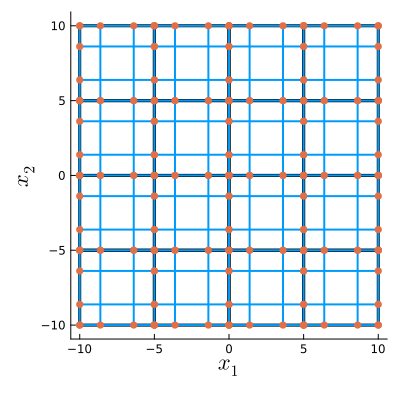

In [20]:
plot(spatial_discretization, grid_connect=true, fmt=:png)

The resulting system of ordinary differential equations can then be solved as usual using OrdinaryDiffEq.jl's `solve` function.

In [21]:
dt = T/1000
reset_timer!()
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false),
            dt=dt, adaptive=false, save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.58s /  97.4%           1.82GiB /  99.9%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 du/dt                  5.05k    1.54s  100.0%   305μs   1.81GiB  100.0%   377KiB
   eval residual        5.05k    1.44s   93.1%   284μs   1.75GiB   96.6%   364KiB
   reconstruct noda...  5.05k    104ms    6.8%  20.7μs   63.4MiB    3.4%  12.8KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each variable (i.e. $\rho$, $\rho V_1$, $\rho V_2$, and $E$) can be computed as follows, where we have opted for an over-integrated Legendre-Gauss (LG) quadrature rule.

In [22]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization, LGQuadrature(3*p))
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T, normalize=true))

L2 error:
[0.004741291979358405, 0.10346265859644528, 0.10168232125253537, 0.4339693000910734]


We'll check that the scheme is indeed conservative by plotting the evolution of the integrated conservative variables. Note that all integrals are evaluated with respect to the scheme's collocated LGL quadrature rule.

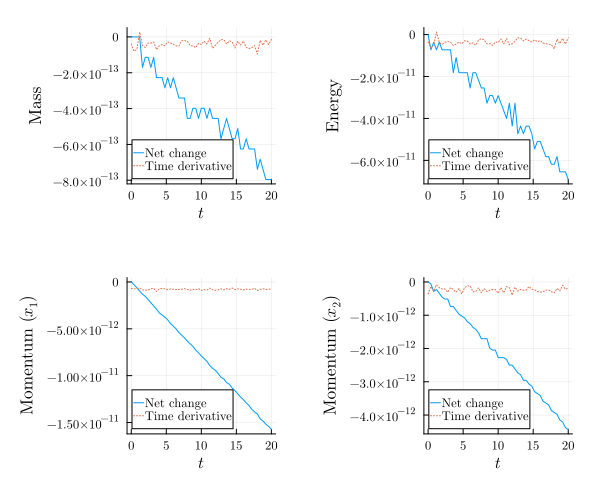

In [23]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
mass = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Mass", 1)
xmom = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Momentum (\$x_1\$)", 2)
ymom = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Momentum (\$x_2\$)", 3)
energy = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Energy", 4)

plot(mass, energy, xmom, ymom, size=(600,500), margin=5mm, fmt=:png)

We can finally plot the evolution of the mathematical entropy $\int_{\Omega} S(U(\boldsymbol{x},t)) \, \mathrm{d} \boldsymbol{x}$, where $S(U(\boldsymbol{x},t)) = - \tfrac{1}{1-\gamma}\rho(\boldsymbol{x},t) \ln(p(\boldsymbol{x},t)/\rho(\boldsymbol{x},t)^\gamma) $, again using the scheme's collocated LGL quadrature rule. Notice that the semi-discrete scheme conserves entropy, as expected.

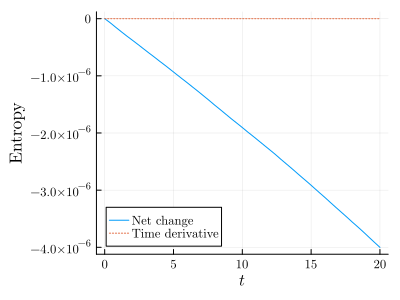

In [24]:
entropy_analysis = EntropyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
entropy_results = analyze(entropy_analysis, load_time_steps(results_path))
entropy = plot(entropy_results, ylabel="Entropy", size=(400,300), fmt=:png)